In [3]:
batch = True#Set this to False to enable plotting.

if not batch:
    %matplotlib inline
    import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist
import numpy as np

import scipy.interpolate as interp
from jax import numpy as jnp
from jax import jit


from functools import partial
    
import pickle


from jax.scipy.optimize import minimize
from jax.random import PRNGKey, split

import tayph.util as ut
import tayph.system_parameters as sp
import tayph.functions as fun
import tayph.util as ut
from tayph.vartests import typetest,notnegativetest,nantest,postest,typetest_array,dimtest
from tayph.vartests import lentest
import tayph.operations as ops
import tayph.masking as masking
import copy

from pathlib import Path

import arviz
from corner import corner

import astropy.io.fits as fits
import astropy.constants as const
import astropy.units as u

from collections import OrderedDict


cpu_cores = 6
numpyro.set_host_device_count(cpu_cores)


print('starting script')

starting script


### Loading opacities.
Opacity functions of various species are located in the `opacity/` folder. We load them using a binary IO script packaged in `tayph`. We save each species in a species object, and keep track of those with a dictionary.

In [4]:
class species:#Species
  def __init__(self, label, tag):
    self.label = label
    self.tag = tag
    

labels=['Fe','Ti','V']
tags=[2600,2200,2300]
S = OrderedDict()#This will hold all my species objects.
for i in range(len(labels)):
    S[labels[i]] = species(labels[i],tags[i])
    
    
for i in list(S.keys()):
    S[i].path = ut.check_path(f'opacity/VALD_{S[i].tag}e2/Out_00000_60000_02500_n800.bin',exists=True)
    S[i].kappa = jnp.array(ut.read_binary_kitzmann(S[i].path,double=False))
    
k_wn = jnp.arange(len(S['Fe'].kappa))*1e-2#Wavenumbers
k_wl = 1e7/k_wn#Wavelength in nm; common to all the opacity functions.

To make a good choice about what to interpolate this onto, we first load in the data. This is copied out of tayph. It's going to prep our hires data for us. It reads spectral orders and wavelengths from file, and generates uncertainties. We also do velocity correction. This is all data preparation.

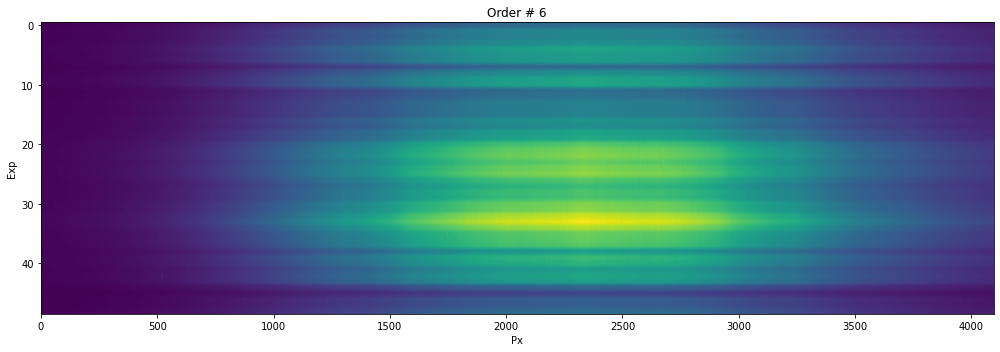

In [5]:
dp = ut.check_path('data/KELT-9/night1/',exists=True)#This follows the file structure of tayph.

air = sp.paramget('air',dp)#Whether or not to convert to air wavelengths. Irrelevant for this demo.
do_berv_correction = True
do_keplerian_correction = True

list_of_wls=[]#This will store all the data.
list_of_orders=[]#All of it needs to be loaded into your memory, more than once.
list_of_sigmas=[]#Hope that's ok...
n_negative_total = 0#This will hold the total number of pixels that were set to NaN because

filelist_orders= [str(i) for i in Path(dp).glob('order_*.fits')]
if len(filelist_orders) == 0:#If no order FITS files are found:
    raise Exception(f'Runtime error: No orders_*.fits files were found in {dp}.')
try:
    order_numbers = [int(i.split('order_')[1].split('.')[0]) for i in filelist_orders]
except:
    raise Exception('Runtime error: Failed at casting fits filename numerals to ints. Are the '
    'filenames of all of the spectral orders correctly formatted (e.g. order_5.fits)?')
order_numbers.sort()#This is the ordered list of numerical order IDs.
n_orders = len(order_numbers)


for i in order_numbers:
    wavepath = dp/f'wave_{i}.fits'
    orderpath= dp/f'order_{i}.fits'
    ut.check_path(wavepath,exists=True)
    ut.check_path(orderpath,exists=True)
    wave_order = ut.readfits(wavepath)#2D or 1D?
    order_i = ut.readfits(orderpath)

    #Check dimensionality of wave axis and order. Either 2D or 1D.
    if wave_order.ndim == 2:

        n_px = np.shape(wave_order)[1]#Pixel width of the spectral order.
        dimtest(wave_order,np.shape(order_i),'wave_order in tayph.run_instance()')
    elif wave_order.ndim == 1:
        n_px = len(wave_order)
        dimtest(order_i,[0,n_px],f'order {i} in run_instance()')
    else:
        raise Exception(f'Wavelength axis of order {i} is neither 1D nor 2D.')

    if i == np.min(order_numbers):
        n_exp = np.shape(order_i)[0]#For the first order, we fix n_exp.
    else:
        dimtest(order_i,[n_exp,n_px],f'order {i} in run_instance()')

    #Deal with air or vaccuum wavelengths:
    if air == False:
        list_of_wls.append(copy.deepcopy(wave_order))
    else:
        list_of_wls.append(ops.airtovac(wave_order))


    #Now test for negatives, set them to NaN and track them.
    n_negative = len(order_i[order_i <= 0])
    n_negative_total+=n_negative
    order_i[order_i <= 0] = np.nan #This is very important for later when we are computing
    #average spectra and the like, to avoid divide-by-zero cases.
    postest(order_i,f'order {i} in run_instance().')#make sure whatever comes out here is
    #strictly positive.
    list_of_orders.append(order_i)
    list_of_sigmas.append(np.sqrt(order_i))

if not batch:    
    oi = 6 #This is the order that's going to be plotted below.
    plt.figure(figsize=(14,5))
    plt.imshow(list_of_orders[oi],aspect='auto')
    plt.title(f'Order # {oi}')
    plt.xlabel('Px')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()











rv_cor = 0#This initialises as an int. If any of the following is true, it becomes a float.
if do_berv_correction:
    rv_cor += sp.berv(dp)
if do_keplerian_correction:
    rv_cor-=sp.RV_star(dp)*(1.0)

gamma = 1.0+(rv_cor*u.km/u.s/const.c)#Doppler factor.


list_of_orders_cor = []
list_of_sigmas_cor = []
list_of_wls_cor = []

for i in range(len(list_of_wls)):
    order = list_of_orders[i]
    sigma = list_of_sigmas[i]
    order_cor = order*0.0
    sigma_cor = sigma*0.0
    if list_of_wls[i].ndim==2:
        wl_cor = list_of_wls[i][0]#Interpolate onto the 1st wavelength axis of the series if 2D.
    elif list_of_wls[i].ndim==1:
        wl_cor = list_of_wls[i]
    else:
        raise Exception(f'Wavelength axis of order {i} is neither 1D nor 2D.')

    for j in range(len(list_of_orders[0])):
        if list_of_wls[i].ndim==2:
            if type(rv_cor) != int:#If wl 2D and rv_cor is non-zero:
                order_cor[j] = interp.interp1d(list_of_wls[i][j]*gamma[j],order[j],bounds_error=False)(wl_cor)
                sigma_cor[j] = interp.interp1d(list_of_wls[i][j]*gamma[j],sigma[j],bounds_error=False)(wl_cor)#I checked that this works because it doesn't affect
                #the SNR, apart from wavelength-shifting it.
            else:#If wl is 2D and rv_cor is not populated, there is no multiplication with gamma
                order_cor[j] = interp.interp1d(list_of_wls[i][j],order[j],bounds_error=False)(wl_cor)
                sigma_cor[j] = interp.interp1d(list_of_wls[i][j],sigma[j],bounds_error=False)(wl_cor)
        else:
            if type(rv_cor) != int:#If wl 1D and rv_cor is non-zero:
                order_cor[j] = interp.interp1d(list_of_wls[i]*gamma[j],order[j],bounds_error=False)(wl_cor)
                sigma_cor[j] = interp.interp1d(list_of_wls[i]*gamma[j],sigma[j],bounds_error=False)(wl_cor)
            else:
                #No interpolation at all:
                order_cor[j]=order[j]
                sigma_cor[j]=sigma[j]

    list_of_orders_cor.append(order_cor)
    list_of_sigmas_cor.append(sigma_cor)
    list_of_wls_cor.append(wl_cor)
    


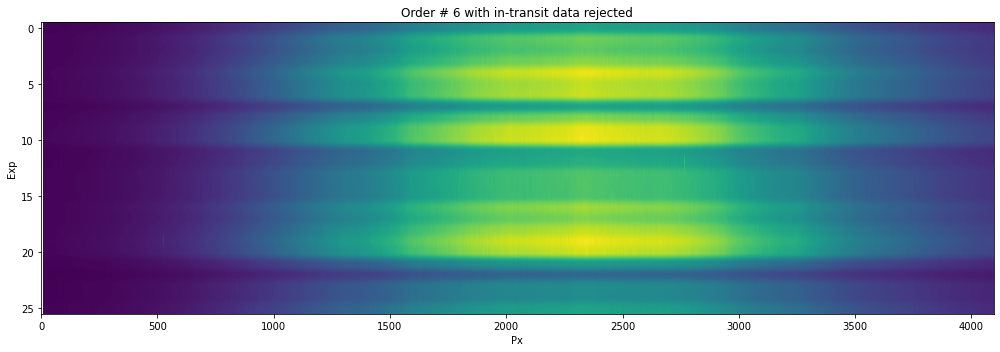

387.5177497257599 430.2120864067213


In [6]:
order_start = 0
order_end = 15

min_wl = np.inf
max_wl = 0


mask = sp.transit(dp)
mask[mask<1]=0

list_of_orders_oot = []
list_of_wls_oot = []
list_of_sigmas_oot = []
for i in range(order_start,np.min([order_end,len(list_of_orders)])):
    list_of_orders_oot.append(list_of_orders_cor[i][mask==1])
    list_of_wls_oot.append(list_of_wls_cor[i])
    list_of_sigmas_oot.append(list_of_sigmas_cor[i][mask==1])
    min_wl = np.min([np.min(list_of_wls_cor[i]),min_wl])
    max_wl = np.max([np.max(list_of_wls_cor[i]),max_wl])
        
list_of_wld = copy.deepcopy(list_of_wls_oot)

if not batch:
    plt.figure(figsize=(14,5))
    plt.imshow(list_of_orders_oot[oi],aspect='auto')
    plt.title(f'Order # {oi} with in-transit data rejected')
    plt.xlabel('Px')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()

n_exp = len(list_of_orders_oot[0])
phase = np.linspace(-0.05,0.05,n_exp)#This will be used later to shift the model.

print(min_wl,max_wl)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


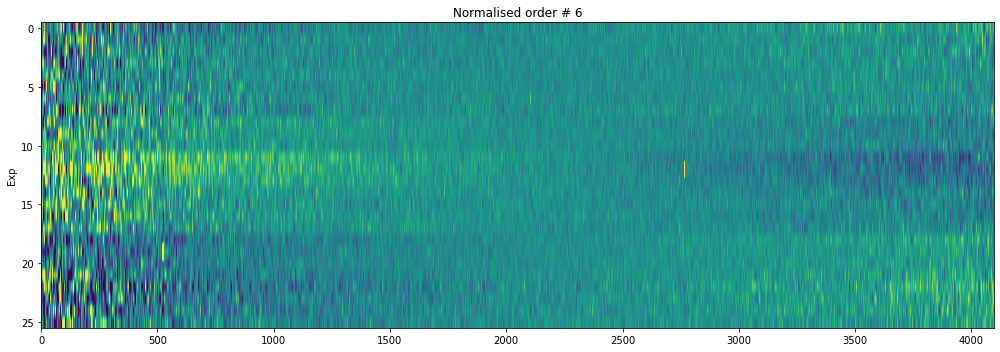

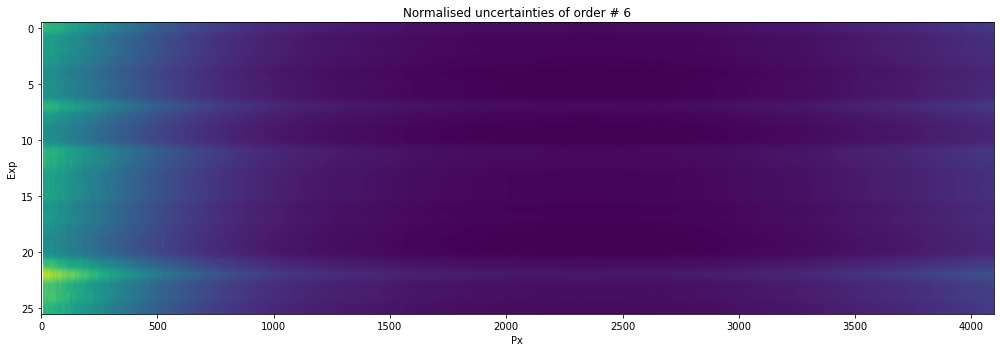

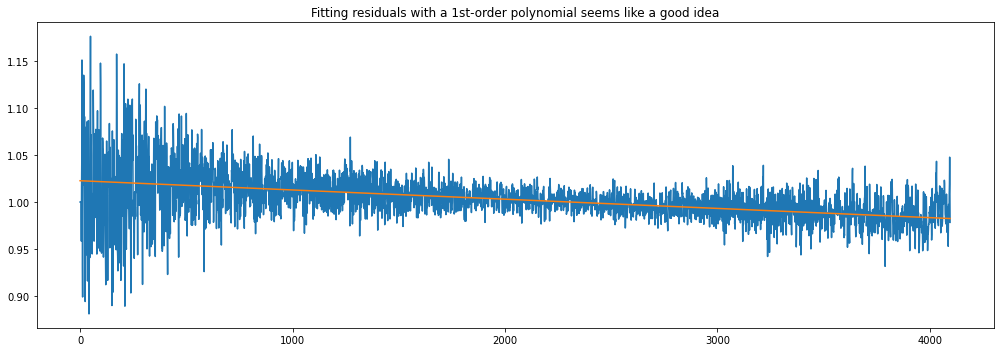

In [7]:

meanfluxes = []#These are the time-dependent average fluxes that we divide out of each order.
meanspecs = []#These are the average spectra that we divide out of each order.
list_of_res = []
list_of_res_e = []

for i in range(len(list_of_orders_oot)):
    order = list_of_orders_oot[i]
    sigma = list_of_sigmas_oot[i]
    meanflux = np.nanmean(order,axis=1)
    meanfluxes.append(meanflux)
    order_norm = (order.T/meanflux).T
    sigma_norm = (sigma.T/meanflux).T
    meanspec = np.nanmean(order_norm,axis=0)
    meanspecs.append(meanspec)
    
    order_clean = order_norm/meanspec
    sigma_clean = sigma_norm/meanspec
    
    #I'm also going to set NaNs to 1.0 and then set sigma to infinite there.
    sigma_clean[np.isfinite(order_clean)==False]=np.inf
    order_clean[np.isfinite(order_clean)==False]=1.0
    
    list_of_res.append(order_clean)
    list_of_res_e.append(sigma_clean)
    
    
if not batch:
    stdev = np.nanmedian(list_of_res_e[oi])    

    plt.figure(figsize=(14,5))
    plt.imshow(list_of_res[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
    plt.title(f'Normalised order # {oi}')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14,5))
    plt.imshow(list_of_res_e[oi],aspect='auto')
    plt.title(f'Normalised uncertainties of order # {oi}')
    plt.xlabel('Px')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()


    expfit = 11
    xfit = np.arange(len(list_of_res[oi][expfit]))
    fit = np.polyfit(xfit, list_of_res[oi][expfit], 1,w = 1/list_of_res_e[oi][expfit])
    plt.figure(figsize=(14,5))
    plt.plot(xfit,list_of_res[oi][expfit])
    plt.plot(xfit,np.poly1d(fit)(xfit))   
    plt.title('Fitting residuals with a 1st-order polynomial seems like a good idea')
    plt.tight_layout()
    plt.show()

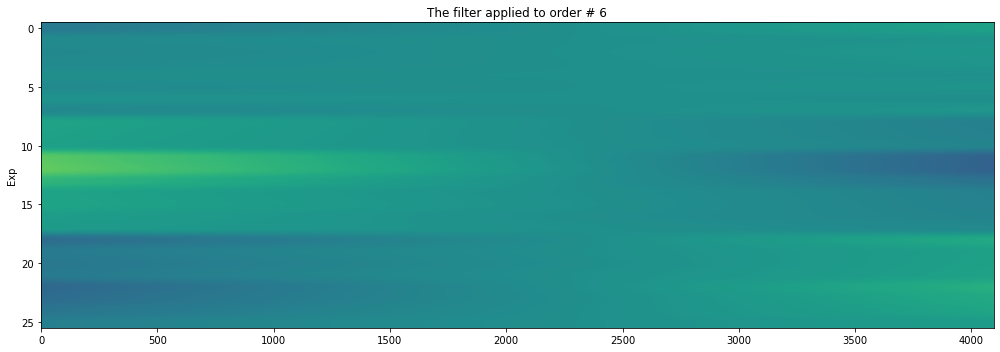

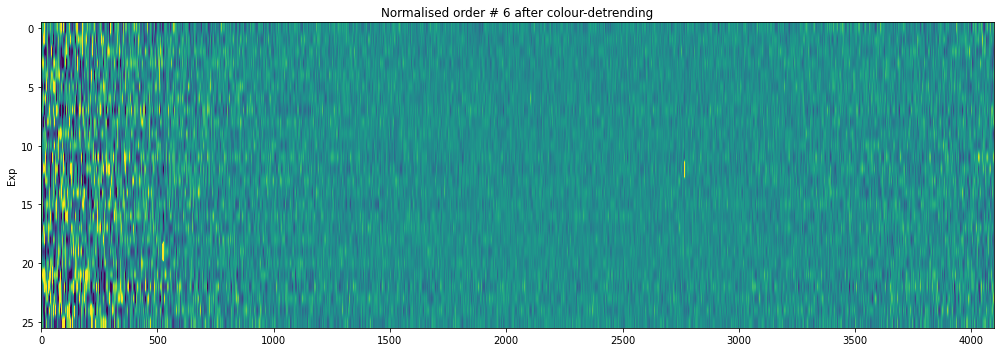

In [8]:
list_of_filters = []
list_of_res_clean = []
list_of_res_clean_e = []
deg = 1
for i in range(len(list_of_res)):
    order = list_of_res[i]
    xfit = np.arange(len(order[0]))
    polyfilter = order*0.0
    fit2d = np.polyfit(xfit,order.T,deg).T

    for j in range(len(order)):
        polyfilter[j] = np.poly1d(fit2d[j])(xfit)
    list_of_filters.append(polyfilter) 
    list_of_res_clean.append(list_of_res[i]/polyfilter)
    list_of_res_clean_e.append(list_of_res_e[i]/polyfilter)
  

if not batch:
    stdev = np.nanmedian(list_of_res_e[oi])


    plt.figure(figsize=(14,5))
    plt.imshow(list_of_filters[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
    plt.title(f'The filter applied to order # {oi}')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14,5))
    plt.imshow(list_of_res[oi]/list_of_filters[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
    plt.title(f'Normalised order # {oi} after colour-detrending')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()


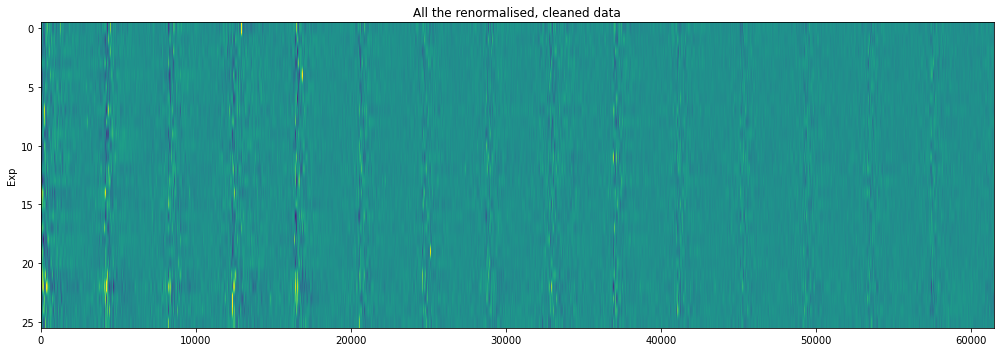

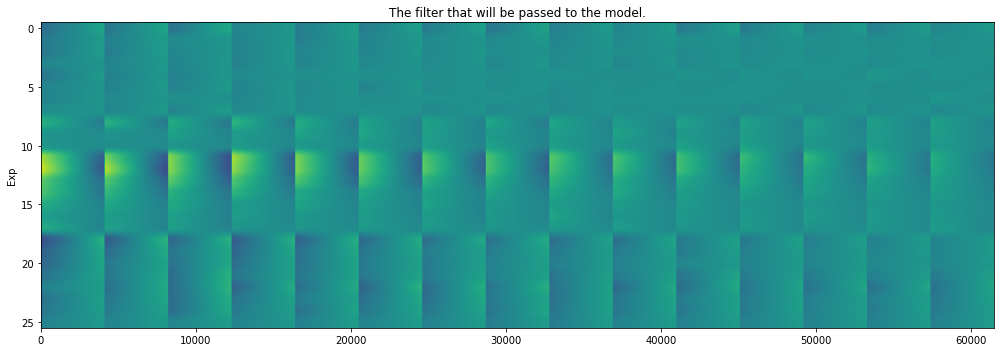

In [9]:
fxd = jnp.hstack(list_of_res_clean) #This is the data.
err = jnp.hstack(list_of_res_clean_e)#This is the uncertainty
fxf = jnp.hstack(list_of_filters)#This is the filter
wld = jnp.hstack(list_of_wld)#This is the wavelength axis.


if not batch:
    plt.figure(figsize=(14,5))
    plt.imshow(fxd,aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
    plt.title(f'All the renormalised, cleaned data')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14,5))
    plt.imshow(fxf,aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
    plt.title(f'The filter that will be passed to the model.')
    plt.ylabel('Exp')
    plt.tight_layout()
    plt.show()

<br><br><br><br>

Now we have the data, with wavelengths, we can go back to the opacities.

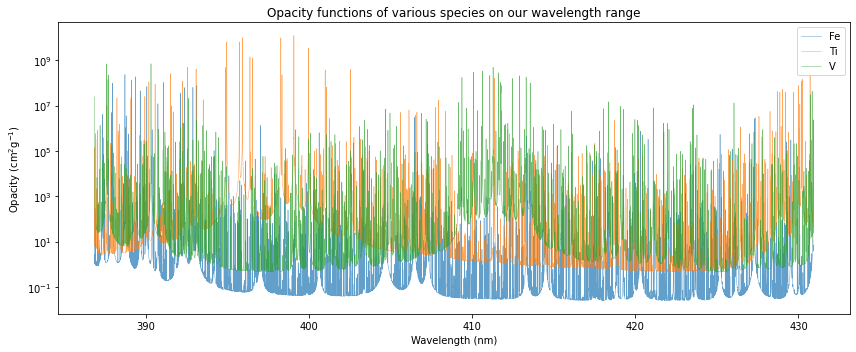

In [10]:
#We are going to bracket the minimum and maximum wavelengths of the intermediate wavelength array by 500 km/s in velocity.
doppler_factor = (500*u.km/u.s / const.c).decompose().value
min_wl*=(1-doppler_factor)
max_wl*=(1+doppler_factor)


for i in list(S.keys()):
    wli,kappa_i,dv = ops.constant_velocity_wl_grid(np.array(k_wl[1:]),np.array(S[i].kappa[1:]),
                                                       oversampling=1.0,minmax=[min_wl,max_wl]) # The intermediate wavelength grid.
                                                        #Index it from 1 onwards because the first value is np.inf.
    S[i].kappa_i = copy.deepcopy(jnp.array(kappa_i))
    
wli = jnp.array(copy.deepcopy(wli))    
    
if not batch:
    plt.figure(figsize=(12,5))

    for i in list(S.keys()):
        plt.plot(wli,S[i].kappa_i,label=i,linewidth=0.5,alpha=0.7)
    plt.yscale('log')
    plt.xlabel('Wavelength (nm)')
    plt.title("Opacity functions of various species on our wavelength range")
    plt.ylabel('Opacity (cm$^2$g$^{-1}$)')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Defining the planet

In [11]:
gamma = 0.57721
RJ = const.R_jup.cgs.value
MJ = const.M_jup.cgs.value
G = const.G.cgs.value
Rsun = const.R_sun.cgs.value

P0 = (1.0*u.bar).cgs.value#bar
R0 = 1.8*RJ
M0 = 1.2*MJ
k = const.k_B.cgs.value
m = 2.33*const.u.cgs.value
Rs = 1.4*Rsun
g = G*M0 / R0**2
c = const.c.to('km/s').value

Prepare all the inputs for the jax function

In [12]:
nwli = len(wli)
nwld = len(wld)
nexp = len(fxf)
# wld_b = wld.tobytes()

kappa_grid = jnp.vstack([S['Fe'].kappa_i,S['Ti'].kappa_i,S['V'].kappa_i])
n_species = len(kappa_grid)#The first species should be Fe.
# kappa_grid_b = kappa_grid.tobytes()
# fxf_b = fxf.tobytes()
# wli_b = wli.tobytes() #This is used later than the others; when the spectrum needs to be shifted & interpolated.
# phase_b = phase.tobytes()

sfwhm = 2*jnp.sqrt(2*np.log(2))#2.355...


#We calculate what range we want for the convolution kernel.
mf=5.0#max_fwhm_expected
nf=4.0#How many times wider the kernel is compared to the fwhm of the lsf?
k_size = int(mf/dv*nf)
if k_size%2 == 0: k_size+=1#Make sure that it is odd.
x_kernel = (jnp.arange(k_size)-(k_size-1)/2)*dv #This places 0 directly in the middle; and serves as the x axis of our convolution. On-the-fly, this will be used to calculate a gaussian with which to convolve.
# x_kernel_b = x_kernel.tobytes()


### Define the model. 


In [13]:
@partial(jit, static_argnums=(6,7,8,9,10,11,12,13,14))
def model_jax(p,wl,wlk,kappa_grid,x_kernel,phase,c,gamma,k,m,g,P0,R0,Rs2,n_species):

    
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering. 
    lw = p[n_species+3]
    vsys = p[n_species+4]
    Kp = p[n_species+5]

    
    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    RT = c0-R**2 / Rs**2
    
    #Then we convolve:
    kernel = jnp.exp(-0.5 * x_kernel**2 / lw**2)
    RT_b = jnp.convolve(RT,kernel/jnp.sum(kernel),mode='same')
    
    #Then we populate the 2D time series:
    rvp = jnp.sin(phase*2*np.pi)*Kp + vsys #Radial velocity of the planet as a function of the orbital phase.
    
    shifted_wl = jnp.outer(1-rvp/c,wl)#This populates a 2D matrix containing a row of shifted wavelengths for each of the spectra.
    spec2D = jnp.interp(shifted_wl,wlk,RT_b) #* filters
    
    return(spec2D)

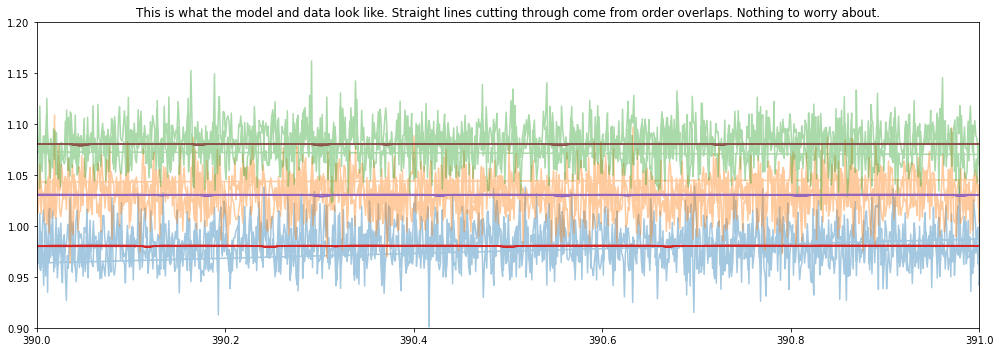

Elapsed time per JAX model: 76.21 ms


In [14]:
true_p = [2500.0,-4.0,-1.0,-2.0,-2.0,1.0,4.0,20.0,150.0]

# phases_b = np.array([-0.05,0.05]).tobytes()
phase = jnp.array([-0.1,-0.75,-0.05,-0.025,0,0.025,0.05,0.75,0.1])
true_downscoped_model = model_downscoped_jax(true_p,wld,wli,kappa_grid,x_kernel,phase,c,gamma,k,m,g,P0,R0,Rs**2,n_species)



NOISE = 0.02


# DATA = true_downscoped_model + np.random.normal(loc=0.0,scale=0.01,size=(2,len(wld)))
DATA = true_downscoped_model + np.random.normal(loc=0.0,scale=NOISE,size=(len(phase),len(wld)))
DATA_E = DATA*0.0+NOISE



if not batch:
    plt.figure(figsize=(14,5))
    plt.plot(wld,DATA[0],alpha=0.4)
    plt.plot(wld,DATA[1]+0.05,alpha=0.4)
    plt.plot(wld,DATA[2]+0.1,alpha=0.4)
    plt.plot(wld,true_downscoped_model[0])
    plt.plot(wld,true_downscoped_model[1]+0.05)
    plt.plot(wld,true_downscoped_model[2]+0.1)
    plt.ylim(0.9,1.2)
    plt.title('This is what the model and data look like. Straight lines cutting through come from order overlaps. Nothing to worry about.')
    plt.xlim(390,391)
    plt.tight_layout()
    plt.show()


N=50
t1=ut.start()
for i in range(N):
    true_downscoped_model = model_downscoped_jax(true_p,wld,wli,kappa_grid,x_kernel,phase,c,gamma,k,m,g,P0,R0,Rs**2,n_species)
t2 = ut.end(t1,silent=True)/N
print(f'Elapsed time per JAX model: {np.round(t2*1000,3)} ms')



In [15]:
print(true_p)

[2500.0, -4.0, -1.0, -2.0, -2.0, 1.0, 4.0, 20.0, 150.0]


In [16]:
def numpyro_model(*args):
    
    T_prior = numpyro.sample('T', dist.Uniform(low=1500, high=3500))
    
    chi_fe_prior = numpyro.sample(
       'log($\chi_{Fe}$)', dist.Uniform(low=-5.0, high=-3.0))
 
    chi_ratio_priors = []#[-1.0,-2.0]
    for i in range(1,len(labels)):
        chi_ratio_priors.append(numpyro.sample('log($\chi_{'+labels[i]+'}$ / $\chi_{Fe}$)', dist.Uniform(low=-3.5, high=-0.5)))
    

    k0_prior = numpyro.sample('log($\kappa_0$)', dist.Uniform(low=-4.0, high=-1.0))

    c_prior = numpyro.sample('c0', dist.Uniform(low=0.998, high=1.002))
    
    lw_prior = numpyro.sample('lw', dist.Uniform(low=2, high=8))
    vsys_prior = numpyro.sample('$v_{sys}$', dist.Uniform(low=16, high=24))
    Kp_prior = numpyro.sample('$K_p$', dist.Uniform(low=130, high=170))
    
    priors = [T_prior,chi_fe_prior]+chi_ratio_priors+[k0_prior,c_prior,lw_prior,vsys_prior,Kp_prior]
    
    # Normally distributed likelihood
    numpyro.sample("obs", dist.Normal(loc=model_jax(priors,wld[100:-100],wli,kappa_grid,
                                                       x_kernel,phase,c,gamma,k,m,g,P0,R0,
                                                       Rs**2,n_species),
                                      scale=DATA_E[:,100:-100]), obs=DATA[:,100:-100])
    #Here I am throwing away edges to make 100% that there are no edge effects due to the convolution or due to the interpolation.

    

In [8]:


    
    
from jax.random import PRNGKey, split
import arviz
from corner import corner
rng_seed = 42
rng_keys = split(PRNGKey(rng_seed),cpu_cores
)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(
    numpyro_model, 
    dense_mass=True
)

# Monte Carlo sampling for a number of steps and parallel chains: 
mcmc = MCMC(
    sampler, 
    num_warmup=500, 
    num_samples=750, 
    num_chains=cpu_cores
)

# Run the MCMC
mcmc.run(rng_keys,priors,wld[100:-100],wli,kappa_grid, x_kernel,phase,c,gamma,k,m,g,P0,R0, Rs**2,n_species)

with open('MCMC-result.pkl','wb') as f:
        pickle.dump(mcmc, f, pickle.HIGHEST_PROTOCOL)
mcmc.print_summary()

NameError: name 'labels' is not defined

In [19]:
#Run the first cell if you haven't already done so.
import pickle5 as pickle
if not batch:
    with open('MCMC-result.pkl', 'rb') as inp:
        mcmc = pickle.load(inp)

    result = arviz.from_numpyro(mcmc)

    truths = {'T': true_p[0], 
               'log($\chi_{Fe}$)': true_p[1], 
              'log($\chi_{Ti}$ / $\chi_{Fe}$)' : true_p[2],
              'log($\chi_{V}$ / $\chi_{Fe}$)' : true_p[3],
              'log($\kappa_0$)': true_p[4], 
              'c0': true_p[5],
              'lw': true_p[6],
              '$v_{sys}$': true_p[7],
              '$K_p$': true_p[8]
             }

    corner(
        result, 
        quiet=True, 
        truths=truths
    );

[2500.0, -4.0, -1.0, -2.0, -2.0, 1.0, 4.0, 20.0, 150.0]

                                      mean       std    median      5.0%     95.0%     n_eff     r_hat
                           $K_p$    153.12      1.81    153.11    150.23    156.09  12896.60      1.00
                       $v_{sys}$     20.10      1.07     20.14     18.35     21.85  13228.92      1.00
                               T   2469.72    359.61   2451.05   1886.44   3078.78   6446.85      1.00
                              c0      1.00      0.00      1.00      1.00      1.00   2595.61      1.01
                log($\chi_{Fe}$)     -3.99      0.57     -4.00     -4.79     -3.02   3092.51      1.01
  log($\chi_{Ti}$ / $\chi_{Fe}$)     -1.65      0.36     -1.66     -2.26     -1.07   8317.58      1.00
   log($\chi_{V}$ / $\chi_{Fe}$)     -2.48      0.43     -2.48     -3.22     -1.79   7989.69      1.00
                 log($\kappa_0$)     -2.64      0.67     -2.65     -3.75     -1.58   2140.31      1.01
                